# Bruges hacking

In [1]:
import bruges
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import welly

## Wavelets

In [2]:
from scipy.signal import hilbert
from scipy.signal import chirp

def sweep(duration, dt, f,
          method='linear',
          phi=0,
          vertex_zero=True,
          autocorrelate=True,
          return_t=False,
         taper='blackman'):

    t0, t1 = -duration/2, duration/2
    t = np.arange(t0, t1, dt)

    f = np.expand_dims(f, 0)
    f1, f2 = f.T

    c = [chirp(t, f1_+(f2_-f1_)/2., t1, f2_, method, phi, vertex_zero)
         for f1_, f2_
         in zip(f1, f2)]

    if autocorrelate:
        A = [np.correlate(c_, c_, mode='same') for c_ in c]
    A = np.squeeze(A) / np.amax(A)
    
    if taper:
        funcs = {
            'bartlett': np.bartlett,
            'blackman': np.blackman,
            'hamming': np.hamming,
            'hanning': np.hanning,
            'none': lambda x: x,
        }
        func = funcs.get(taper, taper)
        A *= func(t.size)


    if return_t:
        Sweep = namedtuple('Sweep', ['amplitude', 'time'])
        return Sweep(A, t)
    else:
        return A

In [3]:
s = sweep(0.064, 0.004, [10, 100])
s

array([ -1.59650205e-18,   2.75409007e-03,  -3.01670223e-03,
        -3.63692317e-02,  -1.63002095e-02,  -5.20943260e-02,
        -2.83497662e-01,   2.76098252e-01,   9.82157437e-01,
         2.38730442e-01,  -2.10312350e-01,  -3.25806534e-02,
        -8.30581776e-03,  -1.39615614e-02,  -6.55916221e-04,
        -2.28078034e-18])

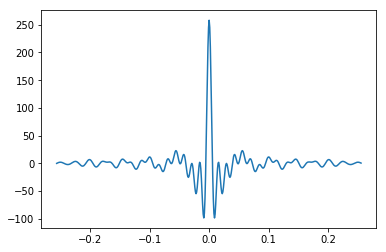

In [5]:
d = 0.512
t0 = -d/2
t1 = d/2
t = np.arange(t0, t1, 0.001)
f1, f2 = f.T
c = [chirp(t, f1_+(f2_-f1_)/2., t1, f2_, 'linear', 0, True) for f1_, f2_ in zip(f1, f2)]
c = [np.correlate(c_, c_, mode='same') for c_ in c]
plt.plot(t, c[0])

In [7]:
s = sweep(0.512, 0.001, [8, 120])

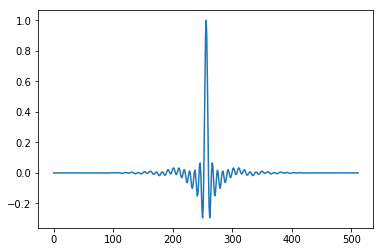

In [8]:
plt.plot(s)

In [10]:
def ormsby(duration, dt, f, return_t=False):
    f = np.expand_dims(f, 0)

    try:
        f1, f2, f3, f4 = f.T
    except ValueError:
        raise ValueError("The last dimension must be 4")

    def numerator(f, t):
        return (np.sinc(f * t)**2) * ((np.pi * f) ** 2)
    
    pf43 = (np.pi * f4) - (np.pi * f3)
    pf21 = (np.pi * f2) - (np.pi * f1)

    t = np.arange(-duration/2, duration/2, dt)

    A = ((numerator(f4, t)/pf43) - (numerator(f3, t)/pf43) -
         (numerator(f2, t)/pf21) + (numerator(f1, t)/pf21))

    A = np.squeeze(A) / np.amax(A)

    if return_t:
        OrmsbyWavelet = namedtuple('OrmsbyWavelet', ['amplitude', 'time'])
        return OrmsbyWavelet(A, t)
    else:
        return A

In [13]:
f = [10, 20, 60, 80]
x = ormsby(0.064, 0.004, f)

In [14]:
x = ormsby(0.256, 0.001, [10, 20, 60, 80])

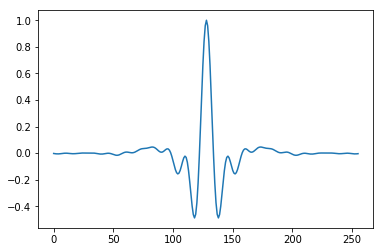

In [15]:
plt.plot(x)

In [16]:
from collections import namedtuple
def sinc(duration, dt, f, return_t=False, taper='hanning'):
    f = np.array(f, dtype=np.float).reshape((-1, 1))
    t = np.arange(-duration/2., duration/2., dt)
    t[t == 0] = 1e-12  # Avoid division by zero.
    f[f == 0] = 1e-12  # Avoid division by zero.
    w = np.squeeze(np.sin(2*np.pi*f*t) / (2*np.pi*f*t))
    
    if taper:
        funcs = {
            'bartlett': np.bartlett,
            'blackman': np.blackman,
            'hamming': np.hamming,
            'hanning': np.hanning,
            'none': lambda x: x,
        }
        func = funcs.get(taper, taper)
        w *= func(t.size)

    if return_t:
        RickerWavelet = namedtuple('RickerWavelet', ['amplitude', 'time'])
        return RickerWavelet(w, t)
    else:
        return w

In [17]:
def taper(l):
    w = np.zeros(l)
    w[int(l/4):-int(l/4)] = 1
    return w

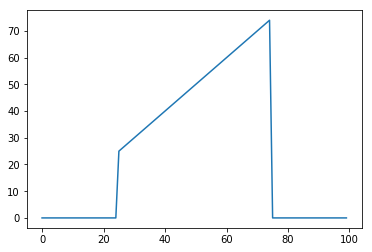

In [18]:
plt.plot(np.arange(100) * taper(100))

In [19]:
y = sinc(0.064, 0.004, np.arange(50, 100), taper=taper)

y[3]

array([-0.        ,  0.        ,  0.        ,  0.        , -0.15321277,
       -0.1887466 ,  0.17251039,  0.72943393,  1.        ,  0.72943393,
        0.17251039, -0.1887466 , -0.        ,  0.        ,  0.        ,  0.        ])

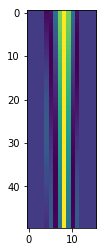

In [20]:
plt.imshow(y)

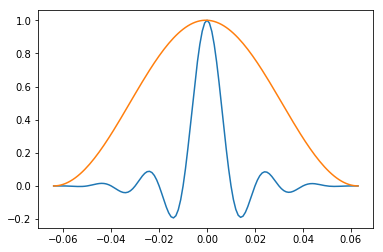

In [22]:
y, t = sinc(0.128, 0.001, 50, return_t=True)

plt.plot(t, y)
plt.plot(t, np.hanning(t.size))

## Banish all loops

Instead of this:

In [33]:
x = np.arange(0, np.pi, 0.05)
z = np.zeros((10, x.size))
for y in np.arange(10):
    z[y, :] = np.sin(y * x)
z.shape

(10, 63)

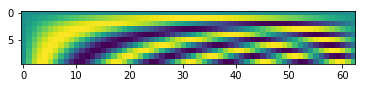

In [34]:
plt.imshow(z);

In [35]:
x = np.arange(0, np.pi, 0.05)
y = np.expand_dims(np.arange(10), -1)
z = np.sin(y * x)

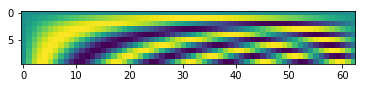

In [36]:
plt.imshow(z);

## Zoeppritz

Is it possible to vectorize Zoeppritz?

In [478]:
from functools import wraps

def vectorize(func):
    """
    Decorator to make sure the inputs are arrays. We also add a dimension
    to theta to make the functions work in an 'outer product' way.

    Takes a reflectivity function requiring Vp, Vs, and RHOB for 2 rocks
    (upper and lower), plus incidence angle theta, plus kwargs. Returns
    that function with the arguments transformed to ndarrays.
    """
    @wraps(func)
    def wrapper(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, **kwargs):
        vp1 = np.array(vp1).astype(float)
        vs1 = np.array(vs1).astype(float) + 1e-12  # Prevent singular matrix.
        rho1 = np.array(rho1).astype(float)
        vp2 = np.array(vp2).astype(float)
        vs2 = np.array(vs2).astype(float) + 1e-12  # Prevent singular matrix.
        rho2 = np.array(rho2).astype(float)
        theta1 = np.array(theta1).reshape((-1, 1))
        return func(vp1, vs1, rho1, vp2, vs2, rho2, theta1, **kwargs)
    return wrapper

@vectorize
def scattering_matrix(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    theta1 = np.radians(theta1).astype(complex) * np.ones_like(vp1)
    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)  # Trans. angle of P-wave.
    phi1 = np.arcsin(p * vs1)    # Refl. angle of converted S-wave.
    phi2 = np.arcsin(p * vs2)    # Trans. angle of converted S-wave.
    
    r1 = np.array([-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)])
    r2 = np.array([np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)])
    r3 = np.array([2 * rho1 * vs1 * np.sin(phi1) * np.cos(theta1),
                   rho1 * vs1 * (1 - 2 * np.sin(phi1)**2),
                   2 * rho2 * vs2 * np.sin(phi2) * np.cos(theta2),
                   rho2 * vs2 * (1 - 2 * np.sin(phi2)**2)])
    r4 = np.array([-rho1 * vp1 * (1 - 2 * np.sin(phi1)**2),
                   rho1 * vs1 * np.sin(2 * phi1),
                   rho2 * vp2 * (1 - 2 * np.sin(phi2)**2),
                   -rho2 * vs2 * np.sin(2 * phi2)])
    M = np.stack([np.squeeze(r1), np.squeeze(r2), np.squeeze(r3), np.squeeze(r4)])

    N = np.array([[np.sin(theta1),np.cos(phi1),-np.sin(theta2), -np.cos(phi2)],
                  [np.cos(theta1),-np.sin(phi1),np.cos(theta2), -np.sin(phi2)],
                  [2 * rho1 * vs1 * np.sin(phi1) * np.cos(theta1),
                   rho1 * vs1 * (1 - 2 * np.sin(phi1)**2),
                   2 * rho2 * vs2 * np.sin(phi2) * np.cos(theta2),
                   rho2 * vs2 * (1 - 2 * np.sin(phi2)**2)],
                  [rho1 * vp1 * (1 - 2 * np.sin(phi1)**2),
                   -rho1 * vs1 * np.sin(2 * phi1),
                   - rho2 * vp2 * (1 - 2 * np.sin(phi2)**2),
                   rho2 * vs2 * np.sin(2 * phi2)]])

    M_ = np.moveaxis(np.squeeze(M), [0, 1], [-2, -1])
    A = np.linalg.inv(M_)
    N_ = np.moveaxis(np.squeeze(N), [0, 1], [-2, -1])
    Z_ = np.matmul(A, N_)

    return np.transpose(Z_, axes=list(range(Z_.ndim - 2)) + [-1, -2])

In [482]:
@vectorize
def zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, element='PdPu'):
    elements = np.array([['PdPu', 'SdPu', 'PuPu', 'SuPu'],
                         ['PdSu', 'SdSu', 'PuSu', 'SuSu'],
                         ['PdPd', 'SdPd', 'PuPd', 'SuPd'],
                         ['PdSd', 'SdSd', 'PuSd', 'SuSd']])

    Z = scattering_matrix(vp1, vs1, rho1, vp2, vs2, rho2, theta1).T

    return np.squeeze(Z[np.where(elements == element)].T)

In [483]:
vp1, vs1, rho1, vp2, vs2, rho2 = 1800, 900, 2200, 2000, 1000, 2500
theta = [0, 10, 20]
s = zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [484]:
s

array([ 0.11607143+0.j,  0.11262716+0.j,  0.10343120+0.j])

In [485]:
vp1, vs1, rho1, vp2, vs2, rho2 = [1800, 2000], [900, 1000], [2200, 2500], [2000, 2100], [1000, 1100], [2500, 2650]
theta = [0, 10, 20]
s = zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [486]:
s[0]

array([ 0.11607143+0.j,  0.05347847+0.j])

In [487]:
vp1, vs1, rho1, vp2, vs2, rho2 = [1800, 2000], [900, 1000], [2200, 2500], [2000, 2100], [1000, 1100], [2500, 2650]
theta = 0
s = zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [488]:
s

array([ 0.11607143+0.j,  0.05347847+0.j])

In [496]:
vp1, vp2 = vp[1000:2010], vp[1001:2011]
vs1, vs2 = vs[1000:2010], vs[1001:2011]
rho1, rho2 = rho[1000:2010], rho[1001:2011]

In [521]:
from bruges.reflection import shuey, zoeppritz_rpp, zoeppritz_element

In [522]:
rpp = [zoeppritz_element(vp1_, vs1_, rho1_, vp2_, vs2_, rho2_, theta, element='PdPu') for vp1_, vs1_, rho1_, vp2_, vs2_, rho2_ in zip(vp1, vs1, rho1, vp2, vs2, rho2)]
rpp_ = np.array(rpp)

In [524]:
rpp = zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [506]:
434/3.12

139.1025641025641

In [525]:
np.allclose(rpp_, rpp)

True

Yes!

## Offset synthetic

In [489]:
import scipy.signal

In [490]:
from scipy import linalg as spla
def convmtx(h, n):
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)

In [491]:
well = welly.Well.from_las('../geocomp-0118/data/R-39.las')

In [492]:
vp = 1e6 / well.data['DT4P']
vs = 1e6 / well.data['DT4S']
rho = well.data['RHOB']

In [6]:
rc = bruges.reflection.reflectivity(vp, vs, rho, theta=np.arange(60))

In [7]:
w = bruges.filters.ricker(0.128, 0.001, 25)

In [8]:
# np.apply_along_axis()
%timeit syn = np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

34.1 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# map()
%timeit syn = np.array(list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)))

35 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# List comprehension.
%timeit syn = np.array([np.convolve(tr, w, mode='same') for tr in rc])

34.8 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
# 2D convolution.
%timeit syn = scipy.signal.fftconvolve(rc, np.expand_dims(w, 0), mode='same')

61.4 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
# 2D convolution.
%timeit syn = scipy.signal.convolve(rc, np.expand_dims(w, 0), mode='same')

68.3 ms ± 578 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# 2D convolution.
%timeit syn = scipy.signal.convolve2d(rc, np.expand_dims(w, 0), mode='same')

221 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# Forward operator and dot product.
G = convmtx(w, rc.shape[1])
%timeit syn = G.T @ rc.T

945 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


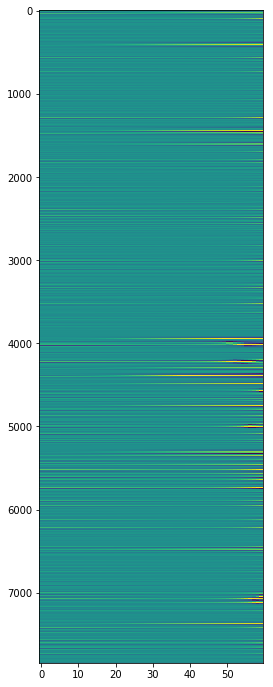

In [114]:
plt.figure(figsize=(4, 12))
plt.imshow(syn.real.T, aspect='auto', vmin=-0.5, vmax=0.5)

In [13]:
syn = np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

In [ ]:
b.transform.CoordTransform

In [150]:
_ = b.filters.wavelets.ricker(0.128, 0.001, 25)

In [151]:
_ = b.filters.ricker(0.128, 0.001, 25)

### Compute reflectivities

In [9]:
vp1, vs1, rho1, vp2, vs2, rho2 = 3500, 2020, 2100, 5500, 3700, 2500
theta = np.arange(0, 90, 0.2)

r = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [69]:
vp1, vs1, rho1, vp2, vs2, rho2 = 1800, 1e-12, 2200, 2500, 1e-12, 2500
theta = np.arange(0, 90, 0.2)

r = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [10]:
vp1, vs1, rho1, vp2, vs2, rho2 = 2000, 900, 2100, 2200, 1200, 2200
theta = np.arange(0, 90, 0.2)

r = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [70]:
a = b.reflection.akirichards_alt(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [71]:
s = b.reflection.shuey(vp1, vs1, rho1, vp2, vs2, rho2, theta, terms=True)
s = s[0] + s[1]

In [72]:
f = b.reflection.fatti(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [73]:
bo = b.reflection.bortfeld(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [74]:
h = b.reflection.hilterman(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [75]:
z = b.reflection.zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta)

In [76]:
zr = b.reflection.zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta)

### Critical angle and phase rotation

In [77]:
ca = np.degrees(np.arcsin(vp1 / vp2))
ca2 = np.degrees(np.arcsin(vp1 / vs2))

/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in arcsin
  from ipykernel import kernelapp as app


In [78]:
p = np.arctan2(np.imag(z), np.real(z))
ph = p.copy() / np.pi

In [79]:
ph[ph==1] = 0

In [80]:
ph[ph<0] = 2 + ph[ph<0]

### Time shift

In [81]:
freq = 5
ts = ph / (2 * freq)

### Plot

/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


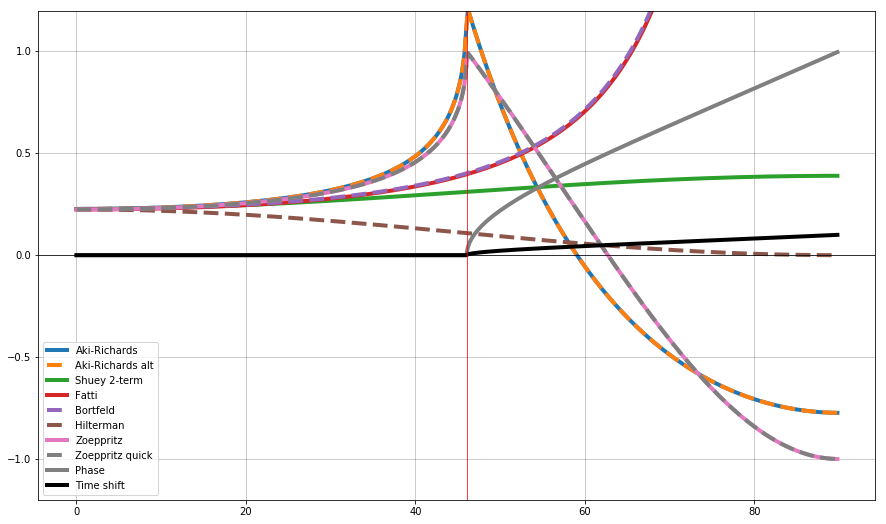

In [82]:
plt.figure(figsize=(15, 9))

plt.plot(theta, r, label='Aki-Richards', lw=4)
plt.plot(theta, a, '--', label='Aki-Richards alt', lw=4)
plt.plot(theta, s, label='Shuey 2-term', lw=4)
plt.plot(theta, f, label='Fatti', lw=4)
plt.plot(theta, bo, '--', label='Bortfeld', lw=4)
plt.plot(theta, h, '--', label='Hilterman', lw=4)
plt.plot(theta, z, label='Zoeppritz', lw=4)
plt.plot(theta, zr, '--', label='Zoeppritz quick', lw=4)
plt.plot(theta, ph, 'gray', label='Phase', lw=4)
plt.plot(theta, ts, 'k', label='Time shift', lw=4)

plt.ylim(-1.2, 1.2)
plt.axhline(0, color='k', lw=0.75)
plt.axvline(ca, color='r', lw=0.75)
plt.axvline(ca2, color='r', lw=0.75)
plt.legend(loc='lower left')
plt.grid(color='k', alpha=0.25)

In [119]:
np.NaN

nan

In [5]:
r_ = b.reflection.akirichards([2000, 2100],  [900, 1000], [2100, 2200],
                             [2200, 2300], [1200, 1300], [2200, 2300],
                             np.arange(90))

In [5]:
b.reflection.zoeppritz_element(2000, 900, 2100, 2200, 1200, 2200, np.arange(90), 'PdSu')

array([ 0.        +0.        j, -0.00574523+0.        j,
       -0.01147971+0.        j, -0.01719273+0.        j,
       -0.02287358+0.        j, -0.02851161+0.        j,
       -0.0340962 +0.        j, -0.03961682+0.        j,
       -0.04506298+0.        j, -0.05042432+0.        j,
       -0.05569057+0.        j, -0.06085156+0.        j,
       -0.06589726+0.        j, -0.07081777+0.        j,
       -0.07560334+0.        j, -0.08024439+0.        j,
       -0.08473149+0.        j, -0.0890554 +0.        j,
       -0.09320706+0.        j, -0.09717762+0.        j,
       -0.10095841+0.        j, -0.104541  +0.        j,
       -0.10791714+0.        j, -0.11107882+0.        j,
       -0.11401826+0.        j, -0.1167279 +0.        j,
       -0.1192004 +0.        j, -0.12142864+0.        j,
       -0.12340574+0.        j, -0.12512503+0.        j,
       -0.12658005+0.        j, -0.12776454+0.        j,
       -0.12867241+0.        j, -0.12929776+0.        j,
       -0.12963482+0.        j,

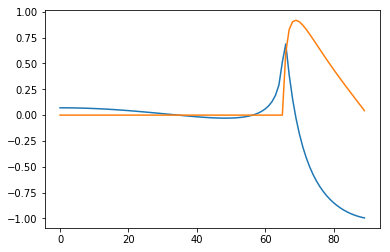

In [8]:
plt.plot(np.real(r))
plt.plot(np.imag(r));

In [4]:
r

array([[0.04286366+0.j, 0.03174603+0.j],
       [0.04153288+0.j, 0.02929003+0.j],
       [0.03800673+0.j, 0.02250897+0.j]])

In [20]:
theta = np.radians(23).astype(complex)

In [22]:
theta.ndim

0

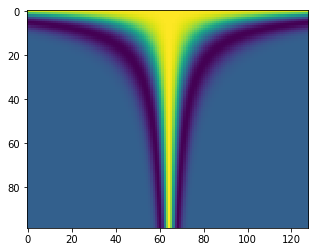

In [6]:
if theta.size == 1:
    theta = np.expand_dims(theta1, axis=1)


In [8]:
w_ = b.filters.rotate_phase(w, 3.14)

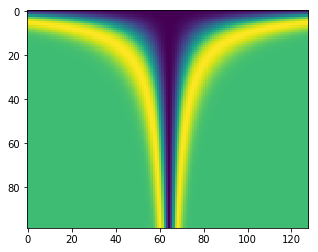

In [9]:
plt.imshow(w_)

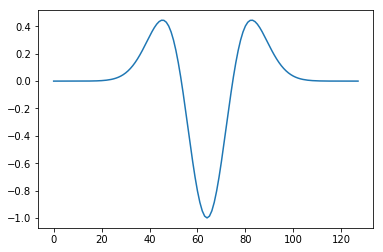

In [10]:
plt.plot(w_[20])

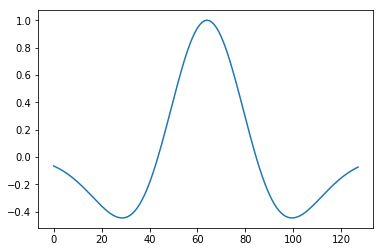

In [22]:
plt.plot(w.T[10])

In [28]:
t.T[10]

-0.05399999999999999

In [15]:
s = b.filters.sweep(0.128, 0.001, [[10, 80], [20, 60]])

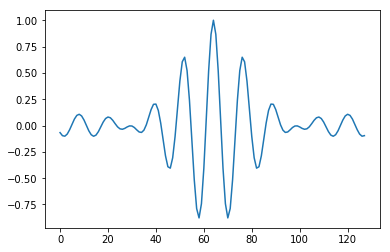

In [18]:
plt.plot(s.T[1])

In [25]:
import scipy.signal
scipy.signal.ricker(200, [1, 2, 3 ])

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [43]:
a, b, c = np.array([1, 2])

ValueError: not enough values to unpack (expected 3, got 2)

In [60]:
f = np.array([[10, 20, 60, 80], [5, 10, 100, 150]])

In [52]:
f = np.array([10, 20, 60, 80])

In [63]:
try:
    f1, f2, f3, f4 = f.T
except ValueError:
    raise ValueError("The last dimension must be 4")


In [64]:
f1, f2

(array([10,  5]), array([20, 10]))

In [62]:
np.array([[10, 20, 60, 80], [5, 10, 100, 150]]).shape

(2, 4)

In [56]:
def rick(duration, dt, f, return_t=False):
    f = np.array(f).reshape((-1, 1))
    t = np.arange(-duration/2, duration/2, dt)
    pft2 = (np.pi * f * t)**2
    w = np.squeeze((1 - (2 * pft2)) * np.exp(-pft2))

    if return_t:
        RickerWavelet = namedtuple('RickerWavelet', ['amplitude', 'time'])
        return RickerWavelet(w, t)
    else:
        return w

In [57]:
r_ = rick(0.128, 0.001, 25)

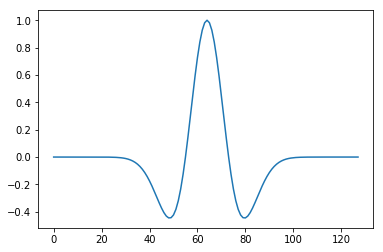

In [58]:
plt.plot(r_)

In [33]:
2.12e-3 / 162e-6

13.08641975308642

In [54]:
r_

array([-5.27136926e-10, -1.11735243e-09, -2.33811714e-09, -4.82996133e-09,
       -9.84949252e-09, -1.98274981e-08, -3.94000151e-08, -7.72839438e-08,
       -1.49635971e-07, -2.85973228e-07, -5.39442926e-07, -1.00434694e-06,
       -1.84555387e-06, -3.34703383e-06, -5.99057676e-06, -1.05812272e-05,
       -1.84435656e-05, -3.17231632e-05, -5.38407112e-05, -9.01625563e-05,
       -1.48970240e-04, -2.42831806e-04, -3.90496539e-04, -6.19448022e-04,
       -9.69251586e-04, -1.49581242e-03, -2.27660888e-03, -3.41686939e-03,
       -5.05650859e-03, -7.37741898e-03, -1.06104261e-02, -1.50408642e-02,
       -2.10113422e-02, -2.89198836e-02, -3.92113167e-02, -5.23596371e-02,
       -6.88391793e-02, -8.90829207e-02, -1.13427193e-01, -1.42043545e-01,
       -1.74860489e-01, -2.11480221e-01, -2.51097984e-01, -2.92434130e-01,
       -3.33690792e-01, -3.72545818e-01, -4.06195877e-01, -4.31458050e-01,
       -4.44934522e-01, -4.43238483e-01, -4.23271408e-01, -3.82533350e-01,
       -3.19439956e-01, -